In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
path = '/Users/dangloan/Documents/learning_analytics/project/'

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', -1)

In [4]:
df = pd.read_csv(path + '3_data/clothing_review/Womens Clothing E-Commerce Reviews.csv')

In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df.columns =['Clothing_ID','Age','Title','Review_Text','Rating',
             'Recommended_IND','Positive_Feedback_Count',
             'Division_Name','Department_Name','Class_Name']

In [7]:
#Clean data - Remove duplicates
df[df.duplicated(keep=False)].sort_values(by='Clothing_ID')
df.drop_duplicates(keep='first',inplace=True)

## Topic modeling by Clothing_ID

I'm trying to see what people complained about a product. Retailers can use the insights to prioritize improvement on the most frequently complained issues. The model segments negative review texts (low rating average, <3), and will give us an idea of what customers complain about the product on a review/purchase. I use topic modeling technique - LDA model. An expected result of the model would be that, for clothing id 1001, a negative review complained mostly about material.

Model output assessment: Human observations, Wordcound visualization.

Delivery: Each low rated Clothing Category receives top 3 prioritized areas of improvement for their product and service.

For products with low ratings (rating <=2)

In [24]:
df_neg = df[df['Rating'] <=3]

In [25]:
df_neg['Review_Text'] = df_neg['Review_Text'].astype(str)

In [26]:
# df2 = df_neg.groupby('Clothing_ID')['Review_Text'].apply(lambda x: x.sum()).reset_index()

In [27]:
df2 = df_neg[['Clothing_ID', 'Class_Name', 'Age', 'Review_Text']]

In [28]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dangloan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dangloan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [60]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
my_words = ['nan','way','back','x','bit','JJS','DT','CD','VBZ','MD', 'RB','rp','wrb','wdt',
            'disappointed','usually','still','bottom','however','item',
            'reason','much','great','definitely','lb','DT','work',
            'x','feel','pair','super','fall','piece','cd',
            'seem','md','coat','beautiful','thought','felt',
            'sad','ordered','someone','perfect',
            'make','wear','love','get','go','order','try','want',
            'run','think','see','review','buy','good',
            'take','come','give','keep','put','need','say','online',
            'bad','nice','cool','dt','rbr','person','purchase',
            'jacket','pants','shirt','dress','sweater','top','skirt','jean','blouse','denim',
           'look','like','really','would',
           'cute','flatter','unflattering']
stop_words = stop_words.union(my_words)

In [61]:
# Clean Review_Text

def clean(text):
    #Remove punctuations
    t = re.sub('[^a-zA-Z]',' ',text)
    #Convert to lowercase
    t = t.lower()
    #Remove tags
    t=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",t)
    #Remove special characters and digits
    t=re.sub("(\\d|\\W)+"," ",t)
    #Convert to list from string
    t = t.split()
    #Remove stopwords
    t = [word for word in t if not word in stop_words]
    
    
    t = " ".join(t)
    return t

df2['Review_Text_cleaned'] = df2['Review_Text'].apply(lambda x: clean(x))

# df2['Review_Text_cleaned1'] =df2['Review_Text_cleaned'].apply(
#     lambda l: [item for sublist in l for item in sublist])
df2['Review_Text_cleaned'].dropna(inplace=True)

In [62]:
#Tokenize
from nltk.tokenize import sent_tokenize
df2['Review_Text_sentences'] = df2['Review_Text_cleaned'].apply(sent_tokenize)

from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

def token_text(text):
    return [w_tokenizer.tokenize(w) for w in text]
df2['Review_Text_tokenized'] = df2['Review_Text_sentences'].apply(token_text)

[nltk_data] Downloading package punkt to /Users/dangloan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [63]:
#POS tagging
from nltk import pos_tag

# def pos_tag(text):
#     return [pos_tag(w) for w in text]
# df2['Review_Text_postag'] = df2['Review_Text_sentences'].apply(pos_tag) ## This function results in an 
#                                                                            ## error "Maximum recursion"

df2['Review_Text_postag'] = df2['Review_Text_tokenized'].apply(lambda sentence:
                        [pos_tag(token) for token in sentence])

In [64]:
# convert Penn treebank tag to wordnet tag
from nltk.corpus import wordnet
def penn_to_wn_tags(pos_tag):
    if pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('J'):
        return wordnet.ADJ
#     elif pos_tag.startswith('R'):
#         return wordnet.ADV
    else:
        return None

# lemmatize text based on POS tags
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def lemmatize_text(text):
#     pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [[wnl.lemmatize(el[0], penn_to_wn_tags(el[1]))
                         if penn_to_wn_tags(el[1]) else el[1]
                         for el in pos_tagged_text]
                         for pos_tagged_text in text]
    
    return lemmatized_tokens

In [65]:
df2['Review_Text_lemmatized'] = df2['Review_Text_postag'].apply(lemmatize_text)

In [66]:
from itertools import chain 
df2['tokens'] = df2['Review_Text_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
df2['tokens'] = df2['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in stop_words and len(token)>1])

In [67]:
##Get some information of the clothing item from df dataset
cat = df_neg[df_neg['Class_Name'] == 'Jeans']
df_cat = df2[df2['Clothing_ID'].isin(cat['Clothing_ID'])]

# Building LDA model

 ## Find the optimal number of topics

In [ ]:
# ! pip install gensim

In [68]:
import itertools
from gensim import corpora, models

import time
from tqdm import tqdm_notebook as tqdm

list_of_list_of_tokens = df2['tokens'].tolist()
dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

start = 1
end = 30
step = 1
topic_range = range(start, end, step)

coherence_values = []
model_list = []
for num_topics in tqdm(topic_range):
    model = models.LdaMulticore(corpus=corpus,num_topics=num_topics,id2word=dictionary_LDA)
    model_list.append(model)
    coherencemodel = models.coherencemodel.CoherenceModel(model=model,
                                                                texts=list_of_list_of_tokens,
                                                                dictionary=dictionary_LDA,
                                                                coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

max_coherence_val = 0
optimal_model = None

# Print the coherence scores
for i, (m,cv) in enumerate(zip(topic_range, coherence_values)):
    if max_coherence_val < round(cv,4):
        optimal_model = model_list[i]
        optimal_num_topics = m
        max_coherence_val = round(cv,4)
        
        print("Numberof topics =", m , "has coherence value of" ,round(cv,4))




/Users/dangloan/miniconda3/envs/py/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Numberof topics = 1 has coherence value of 0.2282
Numberof topics = 2 has coherence value of 0.2628
Numberof topics = 3 has coherence value of 0.268
Numberof topics = 4 has coherence value of 0.2852
Numberof topics = 7 has coherence value of 0.2959
Numberof topics = 10 has coherence value of 0.3013


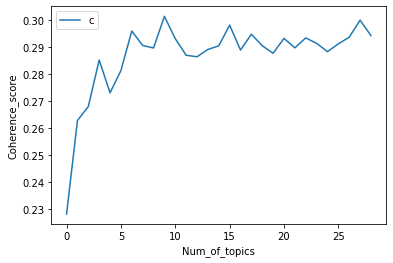

In [69]:
#Plot coherence results
import matplotlib.pyplot as plt
plt.plot(coherence_values)
plt.xlabel("Num_of_topics")
plt.ylabel("Coherence_score")
plt.legend('coherence_values', loc='best')
plt.show() 

In [92]:
import itertools
from gensim import corpora, models

# list_of_list_of_tokens = [["a","b","c"], ["d","e","f"]]
# ["a","b","c"] are the tokens of document 1, ["d","e","f"] are the tokens of document 2...

# df_pos['tokens'] = df_pos['Review_Text_lemmatized'].apply(
#     lambda x : list(itertools.chain.from_iterable(x)))
selected_num_topics = 7
list_of_list_of_tokens = df2['tokens'].tolist()
dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

num_topics = selected_num_topics
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  random_state=123, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

CPU times: user 15.4 s, sys: 53.9 ms, total: 15.4 s
Wall time: 15.6 s


In [ ]:
print('Selected number of topics:', selected_num_topics)

# Compute perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good model is.
                                                             # lower is better
# Compute coherence score
coherence_model_lda = models.coherencemodel.CoherenceModel(model=lda_model,
                                                                texts=list_of_list_of_tokens,
                                                                dictionary=dictionary_LDA,
                                                                coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

In [ ]:
print('Optimal number of topics:', optimal_num_topics)

# Compute perplexity
print('Perplexity: ', optimal_model.log_perplexity(corpus)) # a measure of how good model is.
                                                             # lower is better
# Compute coherence score
coherence_model_lda = models.coherencemodel.CoherenceModel(model=optimal_model,
                                                                texts=list_of_list_of_tokens,
                                                                dictionary=dictionary_LDA,
                                                                coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

From the coherence plot, there are two points of notice: 9 and 26 topics. The objective is to choose the smallest number of topics (lower perplexity score) with highest coherence score. From the coherence score and the perplexity score comparison of the two options, I choose the number of topics at 9.

## Visualize model output

In [93]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.054*"color" + 0.035*"material" + 0.019*"fit" + 0.014*"fabric" + 0.013*"waist" + 0.012*"soft" + 0.010*"picture" + 0.010*"return" + 0.009*"expect" + 0.009*"short" + 0.008*"style" + 0.008*"size" + 0.008*"design" + 0.008*"thin" + 0.008*"cut" + 0.007*"photo" + 0.007*"zipper" + 0.007*"boxy" + 0.007*"red" + 0.006*"cheap"

1: 0.025*"color" + 0.021*"fabric" + 0.018*"fit" + 0.018*"size" + 0.014*"white" + 0.013*"return" + 0.012*"small" + 0.011*"design" + 0.011*"black" + 0.010*"quality" + 0.010*"blue" + 0.009*"store" + 0.008*"retailer" + 0.008*"little" + 0.007*"time" + 0.007*"neck" + 0.007*"sleeve" + 0.007*"itchy" + 0.007*"tight" + 0.006*"front"

2: 0.030*"wash" + 0.020*"fit" + 0.018*"size" + 0.014*"fabric" + 0.014*"short" + 0.011*"line" + 0.010*"time" + 0.010*"dry" + 0.010*"waist" + 0.009*"stretch" + 0.009*"small" + 0.008*"button" + 0.008*"color" + 0.008*"leg" + 0.007*"inch" + 0.007*"comfortable" + 0.007*"front" + 0.006*"hand" + 0.006*"retailer" + 0.006*"year"

3: 0.068*"size" + 0.043*"small

In [85]:
# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
# Here a short legend to explain the vis:
# size of bubble: proportional to the proportions of the topics across the N total tokens in the corpus
# red bars: estimated number of times a given term was generated by a given topic
# blue bars: overall frequency of each term in the corpus
# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [51]:
pyLDAvis.save_html(vis, 'lda_pyLDAvis_181220.html')

### Word Clouds of Top N Keywords in Each Topic

IndexError: list index out of range

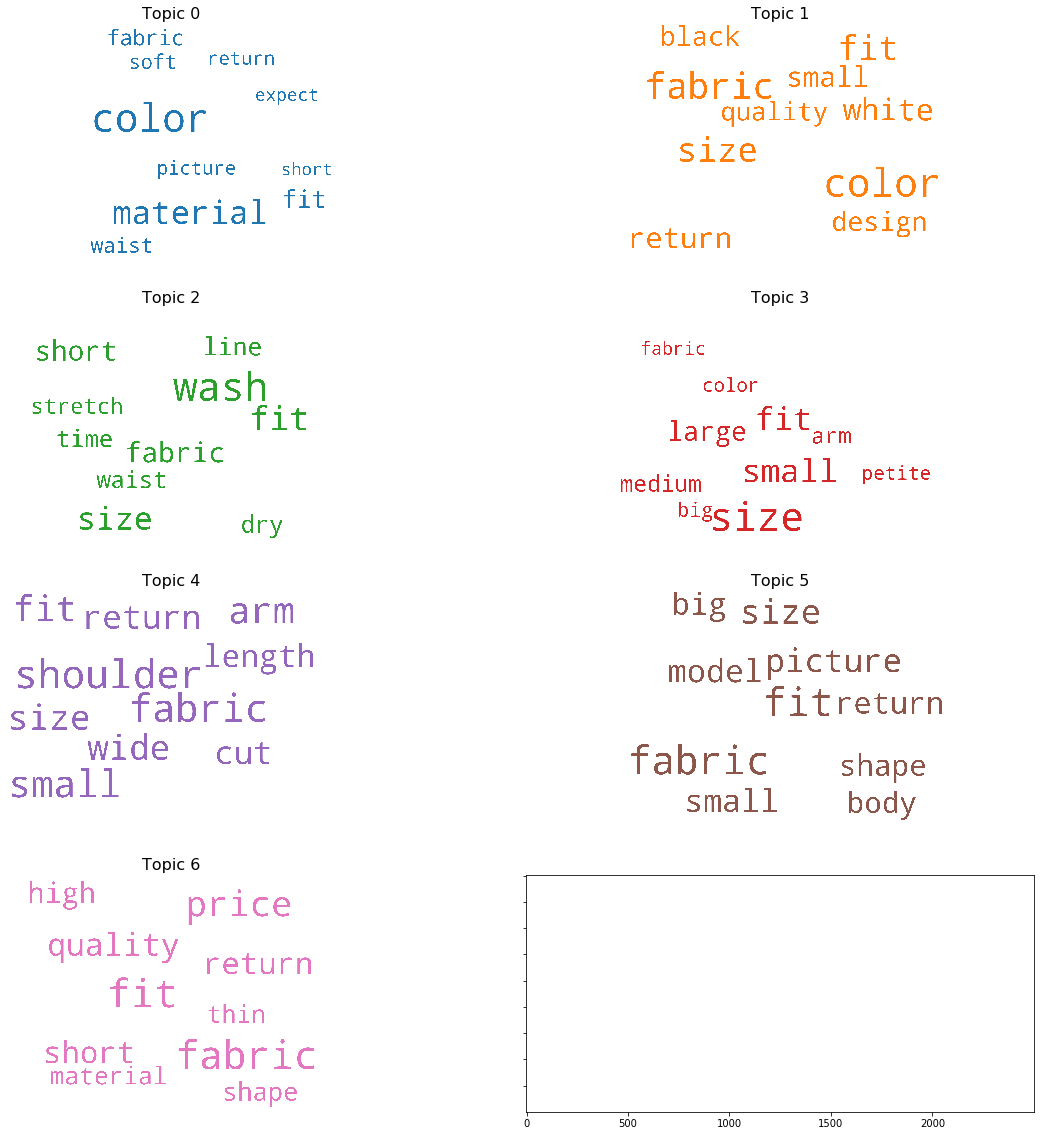

In [94]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Find meaning of topics in negative rating reviews (number of topics = 10):[23072020]\
Topic 0: Color/material\
Topic 1: Color/fabric\
Topic 2: Wash/dry/fit/stretch/fabric\
Topic 3: Size/small\
Topic 4: Shoulder/arm/length/wide/fabric\
Topic 5: Fabric/fit\
Topic 6: Fit/fabric/quality\

In [96]:
def label_theme(row):
    if row['dominant_topic'] == 0 :
        return 'Color/material'
    if row['dominant_topic'] == 1 :
        return 'Color/fabric'
    if row['dominant_topic'] == 2 :
        return 'Wash/dry/fit/stretch/fabric'
    if row['dominant_topic'] == 3:
        return 'Size/small'
    if row['dominant_topic']  == 4:
        return 'Shoulder/arm/length/wide/fabric'
    if row['dominant_topic'] == 5:
        return 'Fabric/fit'
    if row['dominant_topic'] == 6:
        return 'Fit/fabric/quality'


        
# document_topic['dominant_topic_theme'] = document_topic.apply (lambda row: label_theme(row), axis=1)
# document_topic.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,dominant_topic,dominant_topic_theme
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.970738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,9,None
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.958017,0.0,0.0,0.0,0.0,24,None
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.931022,0.0,0.000000,0.0,0.0,0.0,0.0,22,None


### Word Counts of Topic Keywords

<!-- When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process. -->

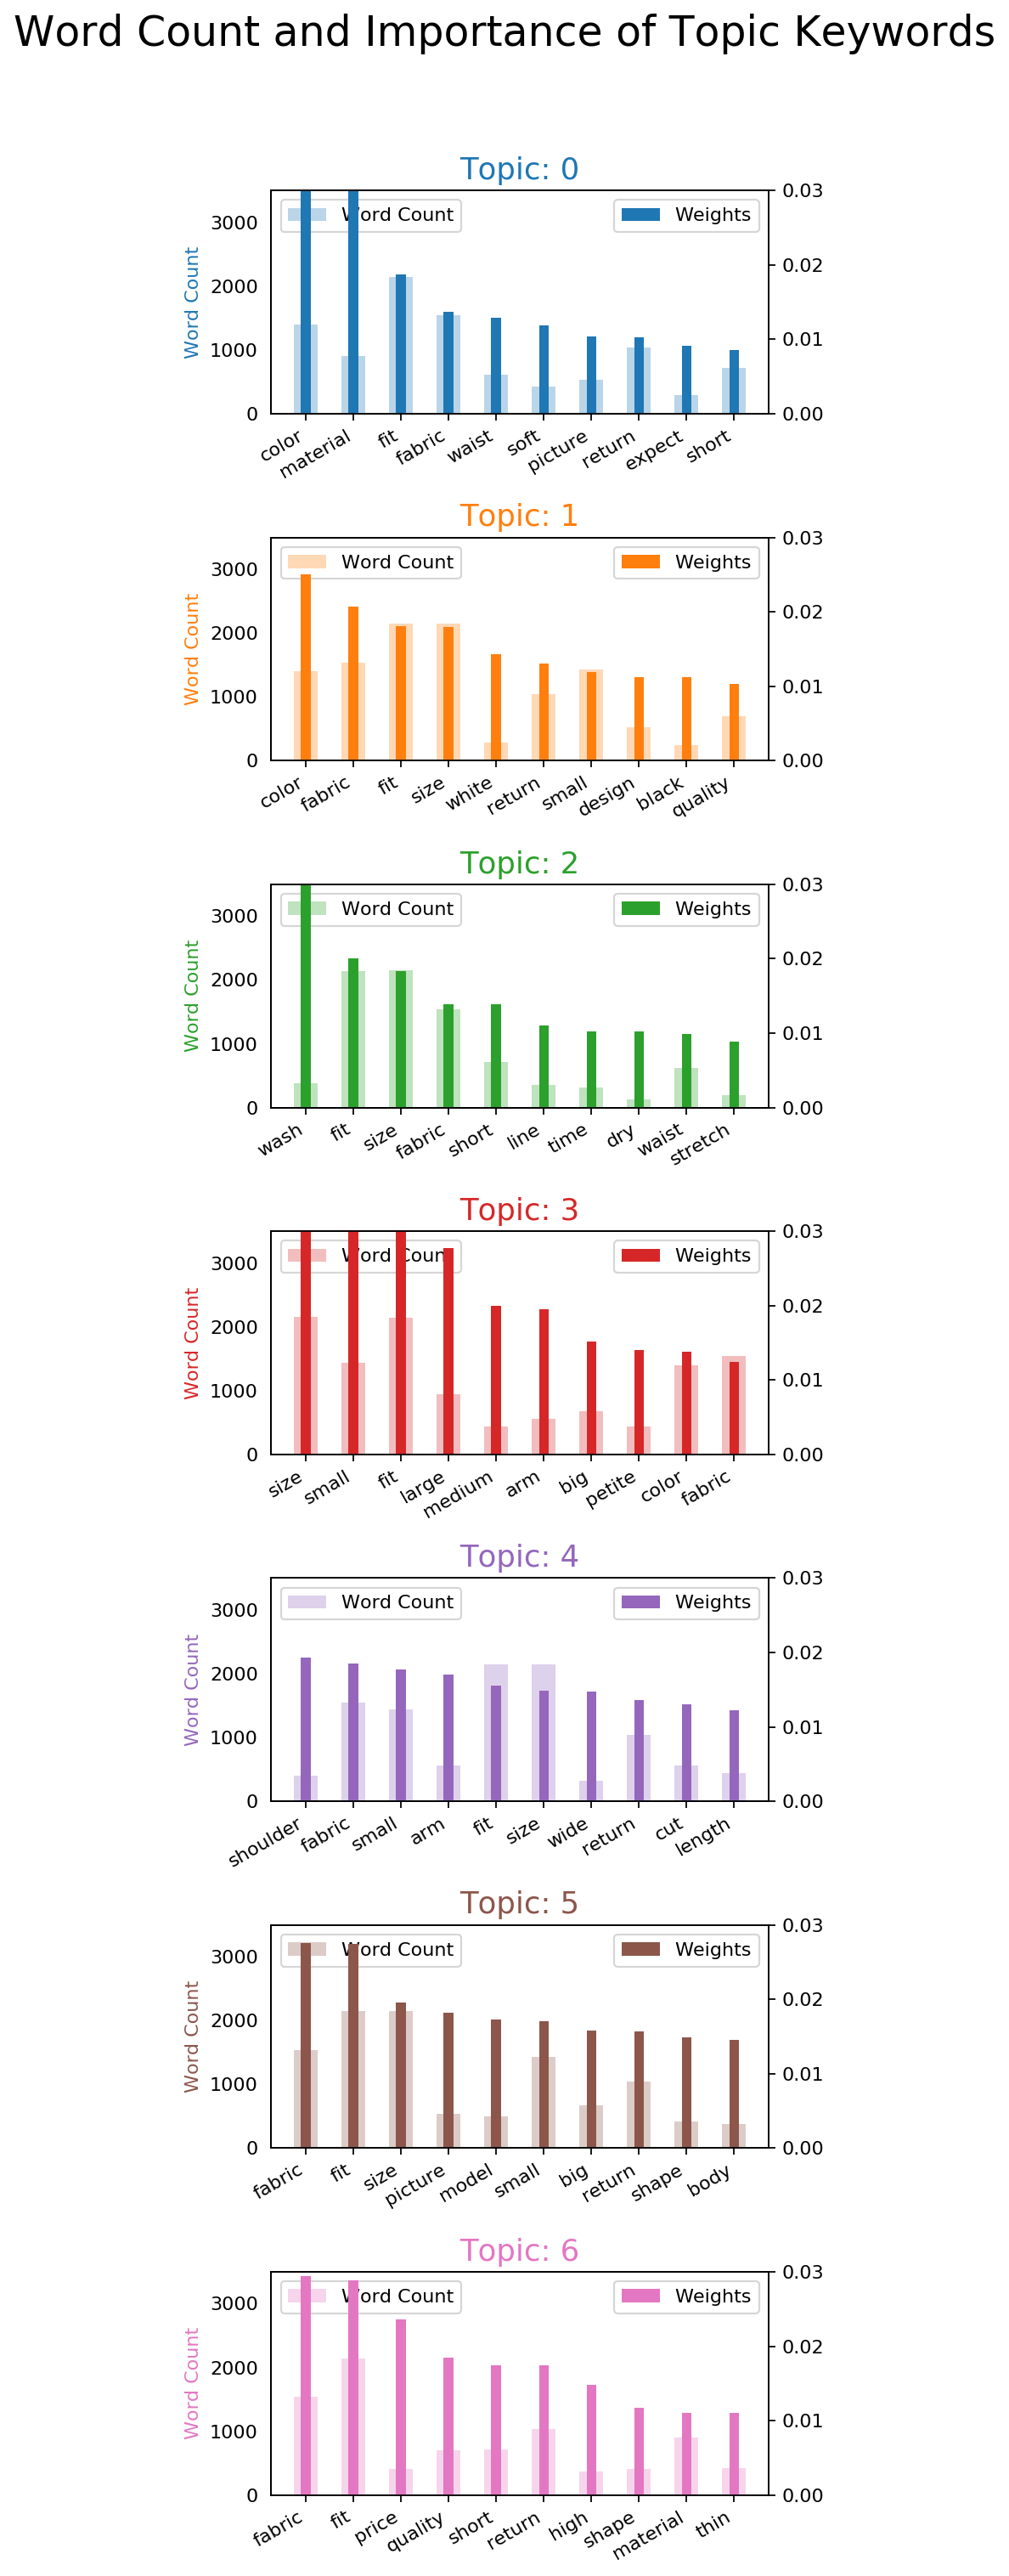

In [125]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in list_of_list_of_tokens for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(7, 1, figsize=(5,18), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [53]:
# Save model to disk.
# temp_file = datapath("model")
model.save('lda.lda_model')
# Load a potentially pretrained model from disk.
lda_model =  models.LdaModel.load('lda.lda_model')

## Assign dominant topic to document

### What is the Dominant topic and its percentage contribution in each document

In [137]:
topics = [lda_model[corpus[i]] for i in range(len(df2))]

In [138]:
len(topics)

5278

In [139]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

In [140]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [144]:
document_topic.head()

,0,1,2,3,4,5,6
0,0.000000,0.250976,0.000000,0.447204,0.000000,0.000000,0.300572
1,0.000000,0.000000,0.000000,0.000000,0.997281,0.000000,0.000000
2,0.219191,0.000000,0.776983,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.300032,0.235087,0.000000,0.463706,0.000000
4,0.000000,0.000000,0.497294,0.097404,0.000000,0.403640,0.000000


In [146]:
dominant_topic = np.argmax(document_topic.values, axis=1)
dominant_topic_perc = np.max(document_topic.values, axis=1)
document_topic['dominant_topic'] = dominant_topic
document_topic['dominant_topic_perc'] = dominant_topic_perc

In [164]:
def label_theme(row):
    if row['dominant_topic'] == 0 :
        return 'Color/material'
    if row['dominant_topic'] == 1 :
        return 'Color/fabric'
    if row['dominant_topic'] == 2 :
        return 'Wash/dry/fit/stretch/fabric'
    if row['dominant_topic'] == 3:
        return 'Size/small'
    if row['dominant_topic']  == 4:
        return 'Shoulder/arm/length/wide/fabric'
    if row['dominant_topic'] == 5:
        return 'Fabric/fit'
    if row['dominant_topic'] == 6:
        return 'Fit/fabric/quality'


        
document_topic['dominant_topic_theme'] = document_topic.apply (lambda row: label_theme(row), axis=1)
document_topic.head(3)

,0,1,2,3,4,5,6,dominant_topic,dominant_topic_perc,dominant_topic_theme
0,0.000000,0.250976,0.000000,0.447204,0.000000,0.0,0.300572,3,0.447204,Size/small
1,0.000000,0.000000,0.000000,0.000000,0.997281,0.0,0.000000,4,0.997281,Shoulder/arm/length/wide/fabric
2,0.219191,0.000000,0.776983,0.000000,0.000000,0.0,0.000000,2,0.776983,Wash/dry/fit/stretch/fabric


In [167]:
x=list(range(0,6,1))
x1 =df2[['Clothing_ID', 'Review_Text']].reset_index()
x1.drop('index', axis=1, inplace=True)
x2=document_topic[['dominant_topic','dominant_topic_perc','dominant_topic_theme'] + x]
y = pd.concat([x1,x2], axis=1)

In [168]:
y.head()

,Clothing_ID,Review_Text,dominant_topic,dominant_topic_perc,dominant_topic_theme,0,1,2,3,4,5
0,1077,I had such high hopes for this dress and really wanted it to work for me. i initially ordered th...,3,0.447204,Size/small,0.000000,0.250976,0.000000,0.447204,0.000000,0.000000
1,1080,"I love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall...",4,0.997281,Shoulder/arm/length/wide/fabric,0.000000,0.000000,0.000000,0.000000,0.997281,0.000000
2,1077,Dress runs small esp where the zipper area runs. i ordered the sp which typically fits me and it...,2,0.776983,Wash/dry/fit/stretch/fabric,0.219191,0.000000,0.776983,0.000000,0.000000,0.000000
3,1077,This is a nice choice for holiday gatherings. i like that the length grazes the knee so it is co...,5,0.463706,Fabric/fit,0.000000,0.000000,0.300032,0.235087,0.000000,0.463706
4,1065,Material and color is nice. the leg opening is very large. i am 5'1 (100#) and the length hits...,2,0.497294,Wash/dry/fit/stretch/fabric,0.000000,0.000000,0.497294,0.097404,0.000000,0.403640


## Number of documents by topic

In [109]:
a = document_topic.groupby('dominant_topic_theme')['dominant_topic'].count().reset_index()
a['percent'] = a['dominant_topic']/(a['dominant_topic'].sum(axis=0))*100
b = a.sort_values(['dominant_topic_theme','dominant_topic'],ascending=[True,False])

In [110]:
b

,dominant_topic_theme,dominant_topic,percent
0,Color/fabric,799,15.138310
1,Color/material,621,11.765820
2,Fabric/fit,796,15.081470
3,Fit/fabric/quality,686,12.997347
4,Shoulder/arm/length/wide/fabric,625,11.841607
5,Size/small,1156,21.902236
6,Wash/dry/fit/stretch/fabric,595,11.273210


[Text(0, 0, 'Size/small'),
 Text(0, 0, 'Color/fabric'),
 Text(0, 0, 'Fabric/fit'),
 Text(0, 0, 'Fit/fabric/quality'),
 Text(0, 0, 'Shoulder/arm/length/wide/fabric'),
 Text(0, 0, 'Color/material'),
 Text(0, 0, 'Wash/dry/fit/stretch/fabric')]

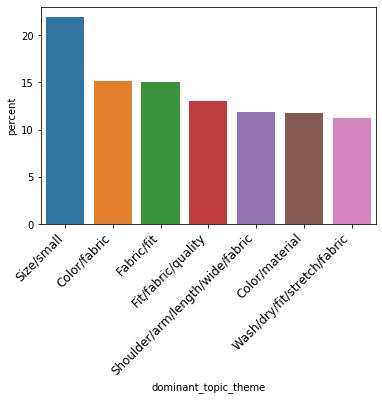

In [115]:
import seaborn as sns
color = [
         'sandybrown', 'sandybrown', 'sandybrown', 'sandybrown',
         'darkkhaki', 'darkkhaki', 'darkkhaki',
         'tan','lightsteelblue']
# plt.figure(figsize=(10,5))
chart = sns.barplot(x='dominant_topic_theme',y='percent',
            data=b.sort_values(['percent'],ascending=[False]))
chart.set_xticklabels(chart.get_xticklabels(), rotation=45,
                     horizontalalignment='right',
                     fontweight='light',
                      fontsize='large')

Insights:
A large portion of negative feedback was on Dress and Top products.

The most frequently complained on Dress items was about size and fitability issues, followed by concerns about fabric/material. There's also a large portion of complains on Dress mentioning wash/color. This can be an issue with the deteriorated quality/color of the Dress after certain times being washed.
Another interesting problem is the issue at zipper and arm area.

Size is a prominant issue. Therefore, for products being complained small in size, the seller should provide more precise sizing information to customers and guarantee that the products are made with appropiate size as listed.

'Tops' category makes up a large portion on negative feedbacks. Customers cared about fabric of the top/shirt, the fit and color.

#### These insights will be compared to exploratory analysis (women_clothing_data_exploration.py) to see if the LDA topic modeling somehow makes sense.

## Validate prediction by screening examples

In [181]:
!pip install openpyxl
sam = y.sample(50)
sam.to_excel(r'/Users/dangloan/Documents/learning_analytics/project/3_data/clothing_review/sample.xlsx', index = False)

    100% |████████████████████████████████| 245kB 2.4MB/s ta 0:00:01
  Stored in directory: /Users/dangloan/Library/Caches/pip/wheels/2a/77/35/0da0965a057698121fc7d8c5a7a9955cdbfb3cc4e2423cad39
Successfully built et-xmlfile


In [173]:
aa = y[y['Clothing_ID'] == 1110]
aa.groupby('dominant_topic_theme')['Clothing_ID'].count()

dominant_topic_theme
Color/fabric                       12
Color/material                     11
Fabric/fit                         17
Fit/fabric/quality                 13
Shoulder/arm/length/wide/fabric    11
Size/small                         30
Wash/dry/fit/stretch/fabric         9
Name: Clothing_ID, dtype: int64

After going through some sample and validate the reliability of the model prediction by 'eyes'. 27/57 reviews are correctly labeled (57%). For cases with dominant topic percentage (weight) is >= 0.9, 10/13 cases are correctly labeled (77%).

I also find out that there are some cases where the model predict incorrectly:\
    - Reviewers mention both on some aspects that they are and aren't satisfied with. The model picks keywords that were positively mentioned.\
    - People don't really express their opinion directly. For example, 'the dress looks like a nightgown on me' (i.e. sizing issue - the dress is too big for this customer). The model wasn't pick up on such a case. Some other cases are ones that show disappointment indirectly or in a ironic way. I haven't found any solution for these problem and would accept model inaccuracy caused by these problems.

I find out that if the second dominant topic is around 0.3, it is worth select it is top topic as well. With that, we can say a review can mention more than 1 major issue of the product.

### Apply topics for Business Analysis:
Question: What are top purchase (top 20%) and negatively reviewed (Rating average (mean) < 3). Analyzie what issues with these products, and send reccommendation to retailers on how they can improve their product.

I'm going to label the topic issues-wise (rather than item-and-issue-wise as the above):

In [ ]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

In [ ]:
def label_theme_issuewise(row):
    if row['dominant_topic'] == 0 :
        return 'Size, fabric, fit'
    if row['dominant_topic'] == 1 :
        return 'Size, fit'
    if row['dominant_topic'] == 2 :
        return 'Fabric, shape'
    if row['dominant_topic'] == 3:
        return 'Fit, white, cheap'
    if row['dominant_topic']  == 4:
        return 'Zipper, fabric'
    if row['dominant_topic'] == 5:
        return 'Fit, size'
    if row['dominant_topic'] == 6:
        return 'Color, fabric'
    if row['dominant_topic'] == 7:
        return 'Fit, size, wash'
    if row['dominant_topic'] == 8:
        return 'Fabric, size, fit'
        
document_topic['dominant_topic_theme1'] = document_topic.apply (lambda row: label_theme_issuewise(row), axis=1)
document_topic.head(3)

In [ ]:
a = document_topic.groupby('dominant_topic_theme1')['dominant_topic'].count().reset_index()
a['percent'] = a['dominant_topic']/(a['dominant_topic'].sum(axis=0))*100
b = a.sort_values(['dominant_topic_theme1','dominant_topic'],ascending=[True,False])
x = ['Dress','Dress','Dress','Dress','Quality, size, hole, jean',
    'Small in size','Top','Top','Top']
b['Topic'] = x
b['percent_group'] = (b['dominant_topic'].groupby(b['Topic']).transform('sum'))/(b['dominant_topic'].sum(axis=0))*100
b.sort_values(['percent'],ascending=[False])
# b.sort_values('percent_group',ascending=False)

In [ ]:
b

In [ ]:
color = [
         'sandybrown', 'sandybrown', 'sandybrown', 'sandybrown',
         'darkkhaki', 'darkkhaki', 'darkkhaki',
         'tan','lightsteelblue']
# plt.figure(figsize=(10,5))
chart = sns.barplot(x='dominant_topic_theme1',y='percent',
            data=b.sort_values(['percent'],ascending=[False]))
chart.set_xticklabels(chart.get_xticklabels(), rotation=45,
                     horizontalalignment='right',
                     fontweight='light',
                      fontsize='large')

In [ ]:
x=list(range(0,9,1))
x1 =df2[['Clothing_ID', 'Class_Name','Review_Text','tokens']].reset_index()
x1.drop('index', axis=1, inplace=True)
x2=document_topic[['dominant_topic','dominant_topic_theme1'] + x]
x3 = pd.concat([x1,x2], axis=1)

In [ ]:
df.head(1)

In [ ]:
df[df['Clothing_ID'] == 872]

In [ ]:
a1 = df.groupby(['Clothing_ID']).agg({'Rating' : 'mean', 'Age' : 'count'}).reset_index()
a2 = a1[a1['Rating']<3]
a3 = a2.nlargest(int(round(len(a1)*0.2,0)),columns=['Age'])
a4 = a3.sort_values(['Rating','Age'],ascending=[True,False])
a4.head()
# print(int(round(len(a1)*0.2,0)))
# a3 = a2.head(int(round(len(a1)*0.2,0)))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# a = df.groupby('Clothing_ID')['Age'].count().reset_index()
b = a2.sort_values(by='Age',ascending=False)
# b['Age'] = b['Age'].astype(int)
b['Clothing_ID'] = b['Clothing_ID'].astype(str)
print(b['Age'].dtype)
print(b['Clothing_ID'].dtype)

fig, ax1 = plt.subplots(figsize=(12,6))
sns.distplot(b['Age'])
plt.xlabel('Count_ProductID')

In [ ]:
a4.describe()

I found out that there should be a method to choose which products need to be prioritized for improvement. I thought of:

- Method 1: Choose top 80% received largest number of reviews (nlargest_count) (dataset 1), then get products with average rating < 3.
This is unreasonable because the rating_mean of dataset 1 is around 4.19 (std ~ 0.3). There really is only one product from dataset 1 that has average rating <3.


- Method 2: Choose products with average rating < 3, then get top 80% received largest number of reviews (nlargest_count). This is also unfeaseable because the final selected products still have very small number of reviews (largely, from 1 to 2 reviews).

What we want is to select products receiving a certain number of negative reviews. These number of reviews should be large enough to show that retailers needs to care for improvement, but not some personal negative reviews (a very small number of negative reviews compared to the total number of reviews/total number of purchases).

In [ ]:
## Method 1:
a1 = df.groupby(['Clothing_ID']).agg({'Rating' : 'mean', 'Age' : 'count'}).reset_index()
a2 = a1.nlargest(int(round(len(a1)*0.2,0)),columns=['Age'])
a3 = a2[a2['Rating'] <3]
print(a3.describe())
print(a2.describe())

In [ ]:
## Method 2:
b0 = df[df['Rating'] <=2]
b1 = b0.groupby('Clothing_ID').agg({'Rating': ['count','mean','median']}).reset_index()
b1.columns = ['Clothing_ID','Rating_count','Rating_mean','Rating_median']
b1.describe()

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,6))
sns.distplot(b1['Rating_count'])

In [ ]:
b2 = b1[b1['Rating_count'] >=6]

On average, a product would receive ~ 6 (mean of Rating_count 6.15) negative reviews (Rating <=2).

In [ ]:
b2.describe()

In [ ]:
c1 = df[df['Clothing_ID'].isin(b2['Clothing_ID'])]
c2 = c1.groupby(['Clothing_ID']).agg({'Rating' : 'mean', 'Age' : 'count'}).reset_index()
# a2 = a1[a1['Rating']<3]
# a3 = a2.nlargest(int(round(len(a1)*0.2,0)),columns=['Age'])
c3 = c2.sort_values(['Rating','Age'],ascending=[True,False])
c3.head()
# print(int(round(len(a1)*0.2,0)))
# a3 = a2.head(int(round(len(a1)*0.2,0)))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
a = df.groupby('Clothing_ID')['Age'].count().reset_index()
b = a2.sort_values(by='Age',ascending=False)
# b['Age'] = b['Age'].astype(int)
b['Clothing_ID'] = b['Clothing_ID'].astype(str)
print(b['Age'].dtype)
print(b['Clothing_ID'].dtype)

fig, ax1 = plt.subplots(figsize=(12,6))
sns.distplot(b['Age'])
plt.xlabel('Count_ProductID')

In [ ]:
e = df.groupby('Clothing_ID')['Rating'].agg({'count','mean'}).reset_index()
e.columns =['Clothing_ID','R_count','R_mean']

print(e.describe())
print(e.R_count.quantile(0.9))

In [ ]:
import seaborn as sns
e1 = e[(e['R_count']>36.5) & (e['R_mean']<4.19)]
# e1 = copy.deepcopy(e)
plt.figure(figsize=(8,8))
sns.scatterplot(e1['R_count'], e1['R_mean'], size = e1['R_count']*e1['R_mean'],
                sizes=(70, 400), color='darkred', alpha=0.6)

In [ ]:
z = x3[x3['Clothing_ID'].isin(e1['Clothing_ID'])]
len(z)

In [ ]:
# e1[e1['R_mean'] <3.7]
e1[e1['R_count'] >350]

In [ ]:
z['Clothing_ID'].nunique()

In [ ]:
# test = z[z['Clothing_ID'] == 1084]
# test = z[z['Clothing_ID'] == 838]
test = z[z['Clothing_ID'] == 868]

In [ ]:
test.groupby(['dominant_topic_theme1'])['Clothing_ID'].count().reset_index()\
            .sort_values('Clothing_ID',ascending=False)

In [174]:
aa = y[y['Clothing_ID'] == 1110]
aa.groupby('dominant_topic_theme')['Clothing_ID'].count()

dominant_topic_theme
Color/fabric                       12
Color/material                     11
Fabric/fit                         17
Fit/fabric/quality                 13
Shoulder/arm/length/wide/fabric    11
Size/small                         30
Wash/dry/fit/stretch/fabric         9
Name: Clothing_ID, dtype: int64

In [176]:
y[y['Clothing_ID'] == 868]

,Clothing_ID,Review_Text,dominant_topic,dominant_topic_perc,dominant_topic_theme,0,1,2,3,4,5
61,868,I liked the color of this top but i didn't really like the ruffled stitching around the middle. it looks like someone just tacked on the bottom half. i bought this for my daughter and she likes it. i think it is comfortable and a good top to knock around in.,5,0.608341,Fabric/fit,0.000000,0.000000,0.386691,0.000000,0.000000,0.608341
62,868,"The styling of this top is really cute. it fits perfectly on the shoulders and gets bigger at the hem for the baby doll look. my biggest complaint is the quality! it's really cheap and feels like the quality i would expect to see at a cheap retailer. it catches lint like crazy and because the hem is just a pearl edge, it curls really badly. i buy quite a bit from here and this is the worst quality item i have seen in a long time. not worth the $$ if paying full price.",6,0.520961,Fit/fabric/quality,0.142686,0.334875,0.000000,0.000000,0.000000,0.000000
63,868,"Like the other reviewer said this top is extremely wide and boxy. it must be pinned in the picture online. it's very frustrating when they do that. thank goodness i didn't pay for shipping! for reference, i'm 5'2 and 135 pounds and bought the xxs, it's going back for sure. i'm trying to lose baby weight, not trying to look pregnant!",5,0.996484,Fabric/fit,0.000000,0.000000,0.000000,0.000000,0.000000,0.996484
243,868,"I order this shirt because it looked like a shirt you could dress up or down. when i got it the shirt was really wrinkled. therefore, i knew it would have to ironed a lot. it was quite boxy and was shorter in the front then in the back. i didn't realize that this shirt was two different fabrics. overall i think this shirt would be more flattering on a woman that was petite.",5,0.676849,Fabric/fit,0.319008,0.000000,0.000000,0.000000,0.000000,0.676849
244,868,Top is very wide and flowy. i am petite with large chest so it hung from widest point and was not flattering. would be very cute with the right body shape.,5,0.601712,Fabric/fit,0.393771,0.000000,0.000000,0.000000,0.000000,0.601712
285,868,"I'm 5""0"" and weigh 105 lbs. i purchased the xxs and it was super-wide, and big all over. it looked like a pregnancy top and did not lay as nicely as shown on the model. also, not shown on the model is the front is short and the back is very long. this would work better on a taller person. i just find it odd that a xxs is still too big. the quality of the fabric and the print is good and the lace-up in the back is cute.",4,0.790883,Shoulder/arm/length/wide/fabric,0.000000,0.000000,0.000000,0.206744,0.790883,0.000000
437,868,Glad i got this on sale. it is more yellow than the photo & short. it is also heavy with a sueded interior. would have given more stars if it was less boxy & longer.,0,0.798379,Color/material,0.798379,0.195424,0.000000,0.000000,0.000000,0.000000
642,868,"I loved this color and ordered it online because i thought it would work for both casual and work days dressed up a little. ummmmm, no. it's weird and boxy and does not look at all like it does on the model. i think maybe if you have no bust whatsoever and size way down it would look okay. i'm only a 34b, weigh 110 pounds, 5'3"" and it made me look huge and awkward. this is going back!",4,0.607875,Shoulder/arm/length/wide/fabric,0.000000,0.000000,0.000000,0.388571,0.607875,0.000000
643,868,"I purchased this top on sale and was really excited about the style. it fit great the first time i wore it. i washed it once, according to the care instructions. after washing it in cold water and allowing it to air dry, it was basically ruined. it shrunk up in length widened out about two inches. i'm pretty bummed about it because it was cute.",2,0.932247,Wash/dry/fit/stretch/fabric,0.000000,0.000000,0.932247,0.065585,0.000000,0.000000
650,868,"I wanted to like this top, as i usually adore a cute peplum feature. when i tried it on yesterday in the store, i was disappointed by h